#Libraries and Data

In [3]:
#import libraries
import numpy as np
import pandas as pd
import itertools
from prophet import Prophet
import yfinance
import pickle
from ta import add_all_ta_features
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
from sklearn import tree
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
#load the data

#data = yfinance.download (tickers = "TATAPOWER.NS",start="2017-03-06",
 #                              interval = "1d", group_by = 'ticker', auto_adjust = True)

#data.tail()

#symbols = ["^NSEI","RELI","HDFCBANK.NS","TATAMOTORS.NS","SBIN.NS","TCS.NS","OLECTRA.NS","CONCOR.NS","ELGIEQUIP.NS","IOC.NS","BEL.NS","TATAELXSI.NS",
#"TITAN.NS","SUNPHARMA.BO","TECHM.NS", "ASIANPAINT.NS","TATACONSUM.NS"]

symbol = "TATACONSUM.NS"
#["OLECTRA.NS","LT.NS","CONCOR.NS","ELGIEQUIP.NS","IOC.NS","BEL.NS","TATAELXSI.NS","^NSEI"]
data = pd.read_csv("../../stock_historical_data/{}.csv".format(symbol))
data.set_index("Date", inplace=True)
data

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,77.434599,78.254013,76.955243,77.782852,952740
2010-01-05,78.254011,86.231004,77.926244,83.813736,7061550
2010-01-06,84.563491,85.907329,82.285522,85.124794,2960980
2010-01-07,86.030254,87.513397,84.645449,85.423889,3807800
2010-01-08,85.792617,88.066491,85.309166,85.849976,2940330
...,...,...,...,...,...
2023-07-10,841.500000,841.500000,822.000000,825.650024,1177214
2023-07-11,826.000000,843.000000,825.750000,840.299988,2167322
2023-07-12,844.950012,847.799988,838.799988,843.250000,1435731


In [5]:
data["Range"] = data["High"] / data["Low"] - 1
data["Avg_Range"] = data["Range"].rolling(window=30).mean()
data.dropna(inplace=True)


In [6]:
# Specify Target
data.loc[data["Range"].shift(-1) > data["Avg_Range"], "TARGET"] = 1
data.loc[data["Range"].shift(-1) <= data["Avg_Range"], "TARGET"] = 0


In [7]:
data.dropna(inplace=True)


#Data preparation

In [8]:
#transform the date variable
data["Date"] = pd.to_datetime(data.index)


In [9]:
#renaming variables
data["y"] = data["Close"]
data = data.rename(columns = {
                     'Date': 'ds'})
data.head(10)
data = data.reset_index()

#Holidays

In [10]:
data  = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


In [11]:
#create training and test set
test_days = 60
training_set = data.iloc[:-test_days,:]
test_set = data.iloc[-test_days:,:]

In [12]:
training_set

,Date,Open,High,Low,Close,Volume,Range,Avg_Range,TARGET,ds,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2010-02-16,78.254005,78.733361,77.278901,77.549309,155220,0.018821,0.038197,0.0,2010-02-16,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.549309,-72.050720,0.000000,0.000000
1,2010-02-17,78.008173,78.323649,76.619267,77.024879,1385110,0.022245,0.038375,0.0,2010-02-17,...,-0.053973,-0.010795,-0.043178,39.830181,7.966036,31.864145,77.304171,-0.676253,-0.678550,-0.676253
2,2010-02-18,77.106821,77.844294,76.942941,77.086334,251740,0.011715,0.035214,0.0,2010-02-18,...,-0.089356,-0.026507,-0.062849,33.822795,13.137388,20.685407,77.203152,0.079786,0.079754,-0.597007
3,2010-02-19,76.914285,77.057685,75.795786,75.951477,138290,0.016649,0.034301,0.0,2010-02-19,...,-0.233227,-0.067851,-0.165376,25.958423,15.701595,10.256828,76.635676,-1.472190,-1.483134,-2.060407
4,2010-02-22,76.697120,76.942947,76.205473,76.238251,262530,0.009677,0.033494,0.0,2010-02-22,...,-0.313956,-0.117072,-0.196884,22.594349,17.080146,5.514203,76.456097,0.377575,0.376864,-1.690612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3246,2023-04-11,718.048118,718.048118,707.909689,709.492249,776167,0.014322,0.015761,0.0,2023-04-11,...,0.172617,-0.309402,0.482019,-5.603778,0.094726,-5.698504,708.005538,-0.464858,-0.465942,814.891776
3247,2023-04-12,713.053049,715.723611,708.552527,710.580261,702063,0.010121,0.015634,0.0,2023-04-12,...,0.210925,-0.205336,0.416261,-7.774061,-1.479031,-6.295029,708.153935,0.153351,0.153233,816.294771
3248,2023-04-13,714.141051,715.822559,709.838425,711.767151,502380,0.008430,0.015553,0.0,2023-04-13,...,0.251869,-0.113895,0.365764,-11.207816,-3.424788,-7.783028,708.465192,0.167031,0.166892,817.825268
3249,2023-04-17,709.195515,711.421024,703.755382,705.436890,1180651,0.010892,0.014940,1.0,2023-04-17,...,0.209645,-0.049187,0.258832,-8.111876,-4.362206,-3.749670,708.279269,-0.889372,-0.893351,809.662382


#Prophet

In [13]:
m = Prophet(
            #holidays = holidays,
            #seasonality_mode = 'multiplicative',
            #seasonality_prior_scale = 20,
           # changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
m.add_regressor('volume_adi')
m.add_regressor('volume_obv')
m.add_regressor('volume_cmf')
m.add_regressor('others_dr')
m.add_regressor('volume_adi')
m.fit(training_set)


19:33:53 - cmdstanpy - INFO - Chain [1] start processing
19:33:58 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
future = pd.DataFrame({"ds" : data.ds})

In [15]:
#forecast
forecast = m.predict(data)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3306,2023-07-07,-103.469252,739.035112,797.598817,-105.382694,-99.344766,870.907811,870.907811,870.907811,864.689703,...,4.592028,4.592028,4.592028,1.626081,1.626081,1.626081,0.0,0.0,0.0,767.438559
3307,2023-07-10,-103.537838,738.366785,796.035103,-105.648097,-99.193210,870.927169,870.927169,870.927169,863.692979,...,5.165338,5.165338,5.165338,2.068852,2.068852,2.068852,0.0,0.0,0.0,767.389331
3308,2023-07-11,-103.560699,742.748982,799.732340,-105.873914,-98.991443,876.526936,876.526936,876.526936,869.293711,...,5.016682,5.016682,5.016682,2.216543,2.216543,2.216543,0.0,0.0,0.0,772.966237
3309,2023-07-12,-103.583561,743.986006,799.764098,-106.133749,-98.793731,876.384431,876.384431,876.384431,868.849826,...,5.170651,5.170651,5.170651,2.363954,2.363954,2.363954,0.0,0.0,0.0,772.800869
3310,2023-07-13,-103.606423,736.753380,795.162409,-106.404455,-98.580555,867.593228,867.593228,867.593228,859.947554,...,5.134576,5.134576,5.134576,2.511098,2.511098,2.511098,0.0,0.0,0.0,763.986805


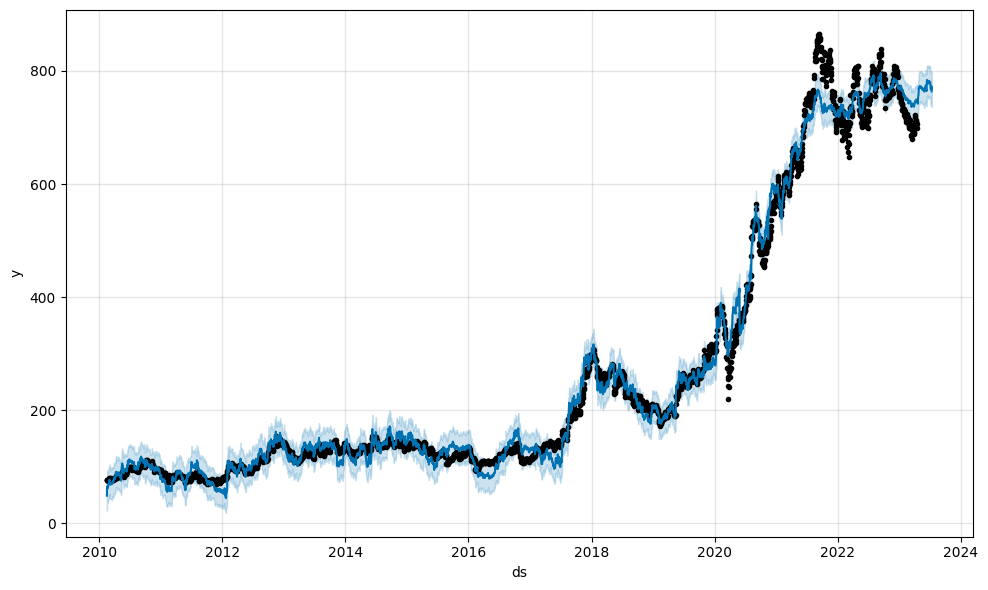

In [16]:
m.plot(forecast);

In [17]:
data = data.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
data = data.drop("index",axis=1)

In [19]:
#get some variables
prophet_variables = forecast.loc[:, ["trend", "weekly", "yearly" ,"multiplicative_terms","trend_upper","trend_lower"]]
df_xgb = pd.concat([data, prophet_variables], axis = 1)
df_xgb.head(1)

,Date,Open,High,Low,Close,Volume,Range,Avg_Range,TARGET,ds,...,momentum_kama,others_dr,others_dlr,others_cr,trend,weekly,yearly,multiplicative_terms,trend_upper,trend_lower
0,2010-02-16,78.254005,78.733361,77.278901,77.549309,155220,0.018821,0.038197,0.0,2010-02-16,...,77.549309,-72.05072,0.0,0.0,894.80744,5.016682,-8.470869,0.0,894.80744,894.80744


In [20]:
df_xgb  = add_all_ta_features(df_xgb, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


In [21]:
    
non_stationaries = []
for col in df_xgb.columns:
    if col != "multiplicative_terms" and col != "Date" and col != "ds" :
        #print(col)
        dftest = adfuller(df_xgb[col].values)
        p_value = dftest[1]
        t_test = dftest[0] < dftest[4]["1%"]
        if p_value > 0.05 or not t_test:
            non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 35


In [22]:
df_stationary = df_xgb.copy()

df_stationary = df_stationary.drop(columns=["Date","ds"])
df_stationary

,Open,High,Low,Close,Volume,Range,Avg_Range,TARGET,y,volume_adi,...,momentum_kama,others_dr,others_dlr,others_cr,trend,weekly,yearly,multiplicative_terms,trend_upper,trend_lower
0,78.254005,78.733361,77.278901,77.549309,155220,0.018821,0.038197,0.0,77.549309,-9.750412e+04,...,77.549309,-72.050720,0.000000,0.000000,894.807440,5.016682,-8.470869,0.0,894.807440,894.807440
1,78.008173,78.323649,76.619267,77.024879,1385110,0.022245,0.038375,0.0,77.024879,-8.233520e+05,...,77.304171,-0.676253,-0.678550,-0.676253,894.661297,5.170651,-8.569572,0.0,894.661297,894.661297
2,77.106821,77.844294,76.942941,77.086334,251740,0.011715,0.035214,0.0,77.086334,-9.949949e+05,...,77.203152,0.079786,0.079754,-0.597007,894.515154,5.134576,-8.668540,0.0,894.515154,894.515154
3,76.914285,77.057685,75.795786,75.951477,138290,0.016649,0.034301,0.0,75.951477,-1.099161e+06,...,76.635676,-1.472190,-1.483134,-2.060407,894.369011,4.592028,-8.771708,0.0,894.369011,894.369011
4,76.697120,76.942947,76.205473,76.238251,262530,0.009677,0.033494,0.0,76.238251,-1.338354e+06,...,76.456097,0.377575,0.376864,-1.690612,893.930582,5.165338,-9.141428,0.0,893.930582,893.930582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,845.049988,852.500000,831.799988,833.250000,1811594,0.024886,0.018776,1.0,833.250000,-1.288570e+08,...,841.717977,-1.396366,-1.406207,974.477662,-103.469252,4.592028,1.626081,0.0,-99.344766,-105.382694
3307,841.500000,841.500000,822.000000,825.650024,1177214,0.023723,0.019147,1.0,825.650024,-1.295935e+08,...,841.127889,-0.912088,-0.916273,964.677477,-103.537838,5.165338,2.068852,0.0,-99.193210,-105.648097
3308,826.000000,843.000000,825.750000,840.299988,2167322,0.020890,0.019558,0.0,840.299988,-1.281046e+08,...,841.067179,1.774355,1.758797,983.568637,-103.560699,5.016682,2.216543,0.0,-98.991443,-105.873914
3309,844.950012,847.799988,838.799988,843.250000,1435731,0.010730,0.019546,0.0,843.250000,-1.281206e+08,...,841.134211,0.351067,0.350452,987.372684,-103.583561,5.170651,2.363954,0.0,-98.793731,-106.133749


In [20]:
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()

#XGBoost preparation

In [23]:
#create training and test set
test_days = 360
training_set = df_xgb.iloc[:-test_days,:]
test_set = df_xgb.iloc[-test_days:,:]


In [24]:
training_set

,Date,Open,High,Low,Close,Volume,Range,Avg_Range,TARGET,ds,...,momentum_kama,others_dr,others_dlr,others_cr,trend,weekly,yearly,multiplicative_terms,trend_upper,trend_lower
0,2010-02-16,78.254005,78.733361,77.278901,77.549309,155220,0.018821,0.038197,0.0,2010-02-16,...,77.549309,-72.050720,0.000000,0.000000,894.807440,5.016682,-8.470869,0.0,894.807440,894.807440
1,2010-02-17,78.008173,78.323649,76.619267,77.024879,1385110,0.022245,0.038375,0.0,2010-02-17,...,77.304171,-0.676253,-0.678550,-0.676253,894.661297,5.170651,-8.569572,0.0,894.661297,894.661297
2,2010-02-18,77.106821,77.844294,76.942941,77.086334,251740,0.011715,0.035214,0.0,2010-02-18,...,77.203152,0.079786,0.079754,-0.597007,894.515154,5.134576,-8.668540,0.0,894.515154,894.515154
3,2010-02-19,76.914285,77.057685,75.795786,75.951477,138290,0.016649,0.034301,0.0,2010-02-19,...,76.635676,-1.472190,-1.483134,-2.060407,894.369011,4.592028,-8.771708,0.0,894.369011,894.369011
4,2010-02-22,76.697120,76.942947,76.205473,76.238251,262530,0.009677,0.033494,0.0,2010-02-22,...,76.456097,0.377575,0.376864,-1.690612,893.930582,5.165338,-9.141428,0.0,893.930582,893.930582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,2022-01-21,707.453519,728.991124,698.622615,712.899231,4854277,0.043469,0.026370,1.0,2022-01-21,...,726.953095,0.428493,0.427577,819.285087,-91.306787,4.592028,0.880303,0.0,-91.306787,-91.306787
2947,2022-01-24,711.378376,711.378376,675.564154,678.458740,3114690,0.053014,0.027018,1.0,2022-01-24,...,724.238627,-4.831046,-4.951641,774.874001,-91.375372,5.165338,-0.595271,0.0,-91.375372,-91.375372
2948,2022-01-25,677.036009,696.611192,662.317835,694.452515,2030546,0.051778,0.027763,1.0,2022-01-25,...,723.189714,2.357369,2.330012,795.498007,-91.398234,5.016682,-1.118388,0.0,-91.398234,-91.398234
2949,2022-01-27,686.848119,696.169630,674.582974,692.686340,3118535,0.032000,0.028136,1.0,2022-01-27,...,722.142723,-0.254326,-0.254650,793.220522,-91.443958,5.134576,-2.181325,0.0,-91.443958,-91.443958


In [25]:
train_y_c = []
for i in range(0,len(training_set)):
    train_y_c.append(training_set.iloc[i].TARGET)


In [26]:
test_y_c = []
for j in range(0,len(test_set)):
    test_y_c.append(test_set.iloc[j].TARGET)

        
#test_y_c

In [27]:
#isolate X and y
y_train = train_y_c
y_test = test_y_c 

X_train = training_set.drop("TARGET",axis=1)

X_test = test_set.drop("TARGET",axis=1)


In [26]:
X_train

,Date,Open,High,Low,Close,Volume,Range,Avg_Range,ds,y,...,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,trend,weekly,multiplicative_terms,trend_upper,trend_lower
0,2010-02-16,78.254005,78.733361,77.278901,77.549309,155220,0.018821,0.038197,2010-02-16,77.549309,...,0.000000,77.549309,-72.050720,0.000000,0.000000,894.807440,5.016682,0.0,894.807440,894.807440
1,2010-02-17,78.008173,78.323649,76.619267,77.024879,1385110,0.022245,0.038375,2010-02-17,77.024879,...,31.864145,77.304171,-0.676253,-0.678550,-0.676253,894.661297,5.170651,0.0,894.661297,894.661297
2,2010-02-18,77.106821,77.844294,76.942941,77.086334,251740,0.011715,0.035214,2010-02-18,77.086334,...,20.685407,77.203152,0.079786,0.079754,-0.597007,894.515154,5.134576,0.0,894.515154,894.515154
3,2010-02-19,76.914285,77.057685,75.795786,75.951477,138290,0.016649,0.034301,2010-02-19,75.951477,...,10.256828,76.635676,-1.472190,-1.483134,-2.060407,894.369011,4.592028,0.0,894.369011,894.369011
4,2010-02-22,76.697120,76.942947,76.205473,76.238251,262530,0.009677,0.033494,2010-02-22,76.238251,...,5.514203,76.456097,0.377575,0.376864,-1.690612,893.930582,5.165338,0.0,893.930582,893.930582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,2022-01-21,707.453519,728.991124,698.622615,712.899231,4854277,0.043469,0.026370,2022-01-21,712.899231,...,8.777585,726.953095,0.428493,0.427577,819.285087,-91.306787,4.592028,0.0,-91.306787,-91.306787
2947,2022-01-24,711.378376,711.378376,675.564154,678.458740,3114690,0.053014,0.027018,2022-01-24,678.458740,...,4.708733,724.238627,-4.831046,-4.951641,774.874001,-91.375372,5.165338,0.0,-91.375372,-91.375372
2948,2022-01-25,677.036009,696.611192,662.317835,694.452515,2030546,0.051778,0.027763,2022-01-25,694.452515,...,-0.381424,723.189714,2.357369,2.330012,795.498007,-91.398234,5.016682,0.0,-91.398234,-91.398234
2949,2022-01-27,686.848119,696.169630,674.582974,692.686340,3118535,0.032000,0.028136,2022-01-27,692.686340,...,-1.518329,722.142723,-0.254326,-0.254650,793.220522,-91.443958,5.134576,0.0,-91.443958,-91.443958


In [28]:
X_train = X_train.drop(columns=["ds","Date"])
X_test = X_test.drop(columns=["ds","Date"])

In [29]:
import xgboost as xgb


In [30]:
model_xgboost = xgb.XGBClassifier(learning_rate=0.1,
                                      min_child_weight=1,
                                      gamma=0,
                                      max_depth=5,
                                      n_estimators=5000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      verbosity=1)


In [30]:
#y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
#y_valid_pred = model_xgboost.predict_proba(X_test)[:,1]

#print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
 #                                                   roc_auc_score(y_test, y_valid_pred)))

In [31]:
learning_rate_list = [0.02, 0.01]
max_depth_list = [2, 3, ]
n_estimators_list = [1000,  3000]
colsample_bytree = [ 0.5, 1]
sample_tree = [ 0.8, 1]
min_child_weight = [0.8,1]

params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list,
               # "colsample_bytree" : colsample_bytree,
               #"subsample" :  sample_tree,
               "min_child_weight" :min_child_weight
              }

num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v) 

print(num_combinations)
params_dict


16


{'learning_rate': [0.02, 0.01],
 'max_depth': [2, 3],
 'n_estimators': [1000, 3000],
 'min_child_weight': [0.8, 1]}

In [32]:
def my_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

model_xgboost_hp = GridSearchCV(estimator=xgb.XGBClassifier(
                                                            eval_metric='auc',
                                                            use_label_encoder=False),
                                                            param_grid=params_dict,
                                                            cv=2,
                                                            scoring=my_roc_auc_score,
                                                            return_train_score=True,
                                                            verbose=4
                                                           )

model_xgboost_hp.fit(X_train, y_train)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END learning_rate=0.02, max_depth=2, min_child_weight=0.8, n_estimators=1000;, score=(train=0.904, test=0.605) total time=   5.9s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=2, min_child_weight=0.8, n_estimators=1000;, score=(train=0.903, test=0.589) total time=   4.8s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=2, min_child_weight=0.8, n_estimators=3000;, score=(train=0.988, test=0.571) total time=  15.6s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=2, min_child_weight=0.8, n_estimators=3000;, score=(train=0.992, test=0.589) total time=  15.5s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=2, min_child_weight=1, n_estimators=1000;, score=(train=0.903, test=0.613) total time=   5.5s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=2, min_child_weight=1, n_estimators=1000;, score=(train=0.903, test=0.587) total time=   5.4s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=2, min_child_weight=1, n_estimators=3000;, score=(train=0.988, test=0.579) total time=  15.5s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=2, min_child_weight=1, n_estimators=3000;, score=(train=0.992, test=0.586) total time=  16.6s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=3, min_child_weight=0.8, n_estimators=1000;, score=(train=0.986, test=0.596) total time=   7.1s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=3, min_child_weight=0.8, n_estimators=1000;, score=(train=0.989, test=0.583) total time=   7.0s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=3, min_child_weight=0.8, n_estimators=3000;, score=(train=1.000, test=0.565) total time=  22.1s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=3, min_child_weight=0.8, n_estimators=3000;, score=(train=1.000, test=0.572) total time=  22.8s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1000;, score=(train=0.986, test=0.605) total time=   7.6s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=1000;, score=(train=0.988, test=0.582) total time=   7.7s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=3000;, score=(train=1.000, test=0.573) total time=  21.6s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.02, max_depth=3, min_child_weight=1, n_estimators=3000;, score=(train=1.000, test=0.574) total time=  21.8s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=2, min_child_weight=0.8, n_estimators=1000;, score=(train=0.834, test=0.624) total time=   4.9s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=2, min_child_weight=0.8, n_estimators=1000;, score=(train=0.841, test=0.592) total time=   4.8s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=2, min_child_weight=0.8, n_estimators=3000;, score=(train=0.943, test=0.590) total time=  15.1s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=2, min_child_weight=0.8, n_estimators=3000;, score=(train=0.943, test=0.588) total time=  15.4s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=1000;, score=(train=0.833, test=0.625) total time=   6.0s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=1000;, score=(train=0.841, test=0.587) total time=   4.8s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=3000;, score=(train=0.942, test=0.601) total time=  15.3s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=3000;, score=(train=0.943, test=0.588) total time=  22.1s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=3, min_child_weight=0.8, n_estimators=1000;, score=(train=0.921, test=0.606) total time=   8.4s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=3, min_child_weight=0.8, n_estimators=1000;, score=(train=0.931, test=0.596) total time=   8.5s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=3, min_child_weight=0.8, n_estimators=3000;, score=(train=0.998, test=0.584) total time=  26.9s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=3, min_child_weight=0.8, n_estimators=3000;, score=(train=0.999, test=0.578) total time=  32.0s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000;, score=(train=0.922, test=0.613) total time=  10.1s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000;, score=(train=0.929, test=0.592) total time=   8.0s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 1/2] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=3000;, score=(train=0.998, test=0.593) total time=  24.0s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV 2/2] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=3000;, score=(train=0.999, test=0.576) total time=  30.4s


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.02, 0.01], 'max_depth': [2, 3],
                         'min_child_weight': [0.8, 1],
                         'n_estimators': [1000, 3000]},
             return_train_score=True,
             scoring=<function my_roc_auc_score at 0x7fd8544418b0>, verbose=4)

In [33]:
df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
df_cv_results.sort_values(by='rank_test_score', inplace=True)
df_cv_results

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators
8,1,0.607884,0.837442,0.01,2,1000
10,2,0.606054,0.836910,0.01,2,1000
14,3,0.602355,0.925804,0.01,3,1000
12,4,0.600965,0.926366,0.01,3,1000
2,5,0.599750,0.903067,0.02,2,1000
0,6,0.597121,0.903367,0.02,2,1000
11,7,0.594530,0.942437,0.01,2,3000
6,8,0.593600,0.986721,0.02,3,1000
4,9,0.589477,0.987549,0.02,3,1000
9,10,0.589082,0.942916,0.01,2,3000


Text(0.5, 1.0, 'Performance wrt # of Trees and Depth')

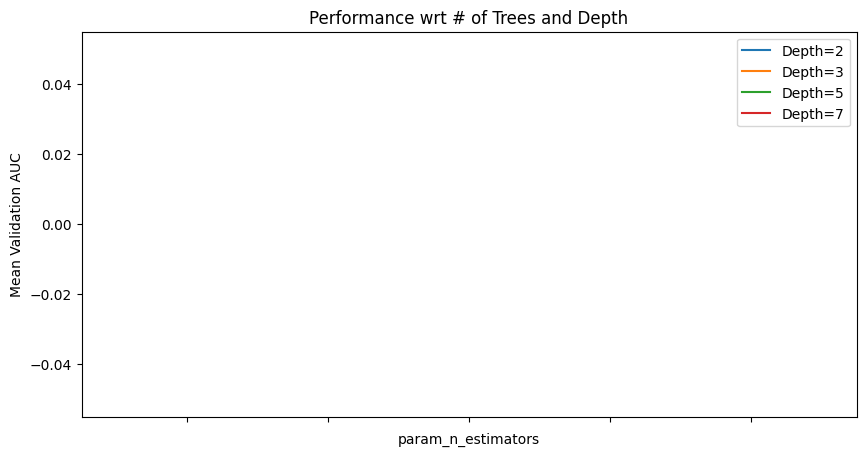

In [34]:
# First sort by number of estimators as that would be x-axis
df_cv_results.sort_values(by='param_n_estimators', inplace=True)

# Find values of AUC for learning rate of 0.05 and different values of depth
lr_d2 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==2),:]
lr_d3 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==3),:]
lr_d5 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==5),:]
lr_d7 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.05) & (df_cv_results['param_max_depth']==7),:]

# Let us plot now
fig, ax = plt.subplots(figsize=(10,5))
lr_d2.plot(x='param_n_estimators', y='mean_test_score', label='Depth=2', ax=ax)
lr_d3.plot(x='param_n_estimators', y='mean_test_score', label='Depth=3', ax=ax)
lr_d5.plot(x='param_n_estimators', y='mean_test_score', label='Depth=5', ax=ax)
lr_d7.plot(x='param_n_estimators', y='mean_test_score', label='Depth=7', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt # of Trees and Depth')

Text(0.5, 1.0, 'Performance wrt learning rate')

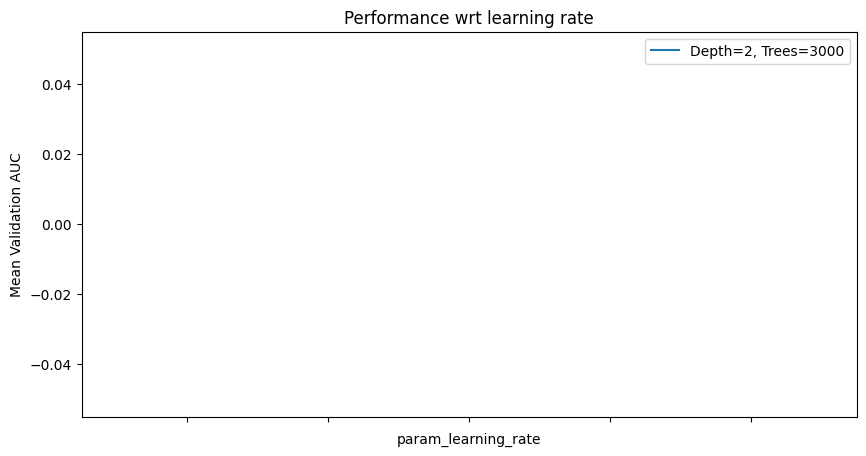

In [35]:
# First sort by learning rate as that would be x-axis
df_cv_results.sort_values(by='param_learning_rate', inplace=True)

# Find values of AUC for learning rate of 0.05 and different values of depth
lr_t3k_d2 = df_cv_results.loc[(df_cv_results['param_n_estimators']==500) & (df_cv_results['param_max_depth']==2),:]

# Let us plot now
fig, ax = plt.subplots(figsize=(10,5))
lr_t3k_d2.plot(x='param_learning_rate', y='mean_test_score', label='Depth=2, Trees=3000', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt learning rate')

In [36]:
df_cv_results.iloc[-1]

rank_test_score              16
mean_test_score        0.567502
mean_train_score            1.0
param_learning_rate        0.02
param_max_depth               3
param_n_estimators         3000
Name: 5, dtype: object

In [36]:
test =False
if test == True:
    lr = 0.2
    max_depth = 2
    n_estimators = 2000
    subsample = 1
    colsample_bytree = 1
else:
    lr = df_cv_results.iloc[-1].param_learning_rate
    max_depth = df_cv_results.iloc[-1].param_max_depth
    n_estimators = df_cv_results.iloc[-1].param_n_estimators
    subsample = 1
    colsample_bytree = 1
    

In [37]:
model_xgboost_fin = xgb.XGBClassifier(learning_rate=lr,
                                          max_depth= max_depth,
                                          n_estimators= n_estimators,
                                          subsample= subsample,
                                          colsample_bytree = colsample_bytree,
                                          eval_metric='auc',
                                          verbosity=1,
                                          use_label_encoder=False)

# Passing both training and validation dataset as we want to plot AUC for both
eval_set = [(X_train, y_train),(X_test, y_test)]

model_xgboost_fin.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.65563	validation_1-auc:0.50604
[1]	validation_0-auc:0.65633	validation_1-auc:0.50625
[2]	validation_0-auc:0.65625	validation_1-auc:0.50612
[3]	validation_0-auc:0.65682	validation_1-auc:0.50625
[4]	validation_0-auc:0.66301	validation_1-auc:0.50713


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-auc:0.66320	validation_1-auc:0.50713
[6]	validation_0-auc:0.66760	validation_1-auc:0.50802
[7]	validation_0-auc:0.66747	validation_1-auc:0.50780
[8]	validation_0-auc:0.66853	validation_1-auc:0.50828
[9]	validation_0-auc:0.67601	validation_1-auc:0.52446
[10]	validation_0-auc:0.68614	validation_1-auc:0.52936
[11]	validation_0-auc:0.68591	validation_1-auc:0.52914
[12]	validation_0-auc:0.68652	validation_1-auc:0.53213
[13]	validation_0-auc:0.68921	validation_1-auc:0.52617
[14]	validation_0-auc:0.69056	validation_1-auc:0.53122
[15]	validation_0-auc:0.69240	validation_1-auc:0.53711
[16]	validation_0-auc:0.69420	validation_1-auc:0.53426
[17]	validation_0-auc:0.69548	validation_1-auc:0.53262
[18]	validation_0-auc:0.69817	validation_1-auc:0.54237
[19]	validation_0-auc:0.69841	validation_1-auc:0.54559
[20]	validation_0-auc:0.69868	validation_1-auc:0.54471
[21]	validation_0-auc:0.70071	validation_1-auc:0.53827
[22]	validation_0-auc:0.70100	validation_1-auc:0.53872
[23]	validation

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=3000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [38]:
y_train_pred = model_xgboost_fin.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost_fin.predict_proba(X_test)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_test, y_valid_pred)))

AUC Train: 0.6984
AUC Valid: 0.5456


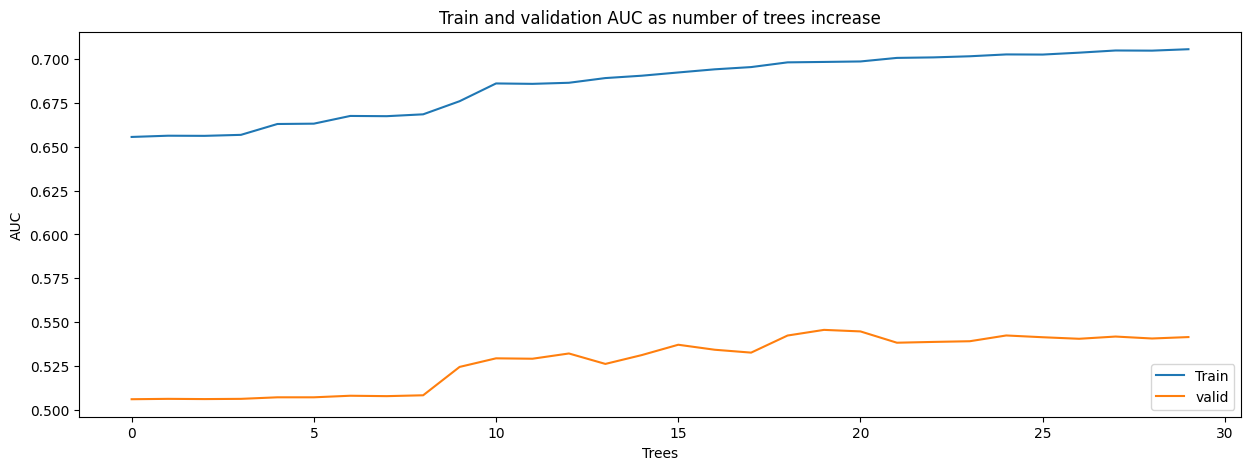

In [40]:
evaluation_results = model_xgboost_fin.evals_result()

# Index into each key to find AUC values for training and validation data after each tree
train_auc_tree = evaluation_results['validation_0']['auc']
valid_auc_tree = evaluation_results['validation_1']['auc']


# Plotting Section
plt.figure(figsize=(15,5))

plt.plot(train_auc_tree, label='Train')
plt.plot(valid_auc_tree, label='valid')

plt.title("Train and validation AUC as number of trees increase")
plt.xlabel("Trees")
plt.ylabel("AUC")
plt.legend(loc='lower right')
plt.show()

In [41]:
df_var_imp = pd.DataFrame({"Variable": X_test.columns,
                           "Importance": model_xgboost_fin.feature_importances_}) \
                        .sort_values(by='Importance', ascending=False)
df_var_imp[:20]

,Variable,Importance
5,Range,0.107118
22,volatility_bbp,0.082565
6,Avg_Range,0.080492
89,momentum_pvo_hist,0.075601
29,volatility_kcp,0.069600
53,trend_kst_sig,0.055606
87,momentum_pvo,0.046715
79,momentum_stoch,0.046167
12,volume_em,0.040336
50,trend_mass_index,0.036595


In [42]:
#Visualization
training_set.index = training_set.ds
test_set.index = test_set.ds

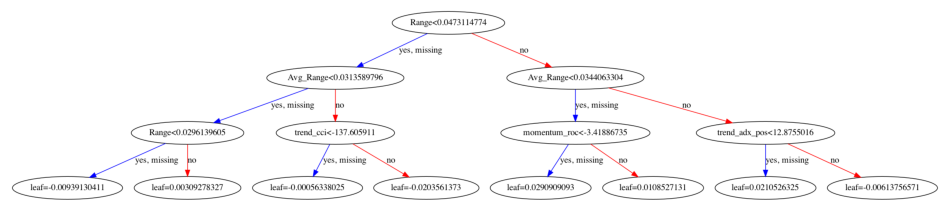

In [43]:
rcParams["figure.figsize"] = 100, 50
dir(model_xgboost_fin)
tree_index = 0  # Index of the tree you want to plot
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_tree(model_xgboost_fin, num_trees=tree_index, ax=ax)
plt.show()

In [44]:
# Save the trained model to a file

with open('../../TrainedModel/ranage_xg/{}_model_2.pkl'.format(symbol), 'wb') as f:
    pickle.dump(model_xgboost_fin, f)

In [45]:
# Save the trained model to a file

with open('../../TrainedModel/ranage_xg/{}_model_phrophet.pkl'.format(symbol), 'wb') as f:
    pickle.dump(m, f)